<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/Traffic-Sign-Classification-with-Fine-Tuned-VGG-16/blob/main/Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [ ]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file(
    'https://www.dropbox.com/s/41o9vh00rervwn9/dataset_traffic_signs_40_samples_per_class.zip?dl=1',
    'dataset_traffic_signs_40_samples_per_class.zip'
)

unzip(zip_file='dataset_traffic_signs_40_samples_per_class.zip')

Extracted all


In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = './dataset_traffic_signs_40_samples_per_class/Train'
    DATA_ROOT_VALID:  str = './dataset_traffic_signs_40_samples_per_class/Valid'
    DATA_ROOT_TEST:   str = './dataset_traffic_signs_40_samples_per_class/Test'
    DATA_TEST_GT:     str = './dataset_traffic_signs_40_samples_per_class/Test.csv'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [ ]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int',        # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [ ]:
# Display the class names from the training dataset.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


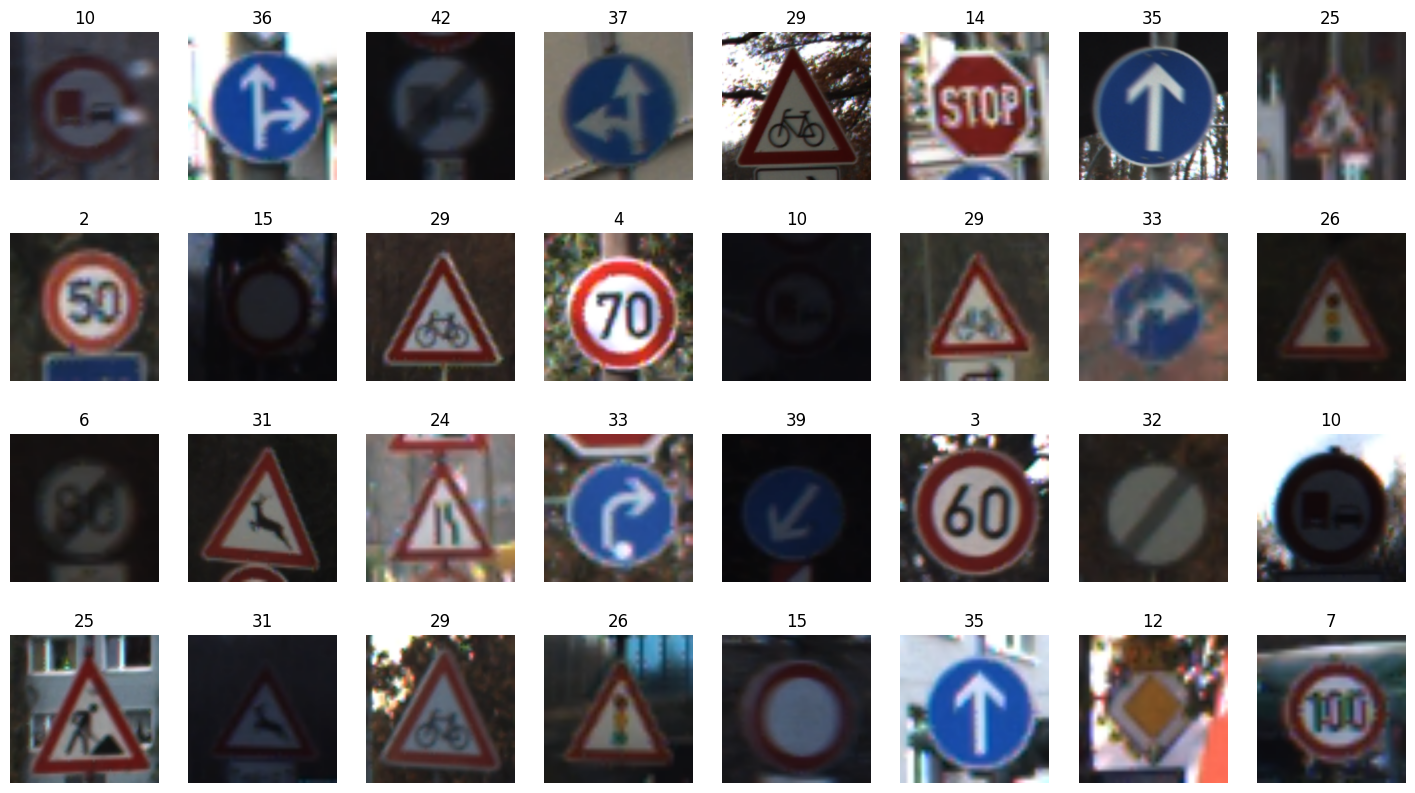

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18,10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

Create the Test Dataset
It was easy to create the training and validation datasets using image_dataset_from_directory(). However, since the images and labels for the Test dataset are stored separately on the filesystem, we’ll need to write some custom code to read and load this data. To create the test dataset, we will need to load the images and the labels in memory and combine them to create a (tf.data.Dataset) test dataset. Four steps are required:

1. Retrieve the class labels from the provided csv file and store them in memory
as a Python list.

2. Build a list of the image file paths in memory as a Python list.

3. Combine the image paths and associated labels in a tf.data.Dataset object.

4. Use the dataset object map method to the load and preprocess the images in the dataset


In [ ]:
import pandas as pd

input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
# print(df.head())

# df = df[df.columns[6]]
ground_truth_ids = df['ClassId'].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


In [ ]:
# convert train/validation class names to integers
class_names_int=list(map(int,train_dataset.class_names))

print(class_names_int)
#create a directory mapping ground truth IDs to class name IDs
gtid_2_cnidx=dict(zip(class_names_int,range(0,DatasetConfig.NUM_CLASSES)))
print(gtid_2_cnidx)

gtid_2_cnidx.items()

[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 5, 6, 7, 8, 9]
{0: 0, 1: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7, 16: 8, 17: 9, 18: 10, 19: 11, 2: 12, 20: 13, 21: 14, 22: 15, 23: 16, 24: 17, 25: 18, 26: 19, 27: 20, 28: 21, 29: 22, 3: 23, 30: 24, 31: 25, 32: 26, 33: 27, 34: 28, 35: 29, 36: 30, 37: 31, 38: 32, 39: 33, 4: 34, 40: 35, 41: 36, 42: 37, 5: 38, 6: 39, 7: 40, 8: 41, 9: 42}


dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [ ]:
# Convert the ground truth Class IDs to IDs that correctly map to the same classes
# in the train and validation datasets.
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])

# print(label_ids)
print('Original ground truth class IDs: ',ground_truth_ids[0:10])
print('New mapping required:            ',label_ids[0:10])

print('')
print('Train/Valid dataset class names: ',train_dataset.class_names)

Original ground truth class IDs:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + '/*.png'))

print(len(image_paths))
print('')
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])

12630

./dataset_traffic_signs_40_samples_per_class/Test/00000.png
./dataset_traffic_signs_40_samples_per_class/Test/00001.png
./dataset_traffic_signs_40_samples_per_class/Test/00002.png
./dataset_traffic_signs_40_samples_per_class/Test/00003.png
./dataset_traffic_signs_40_samples_per_class/Test/00004.png


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))


In [ ]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT])
    return image

In [ ]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [ ]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label


In [ ]:
# Apply the functions above to the test dataset.
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)


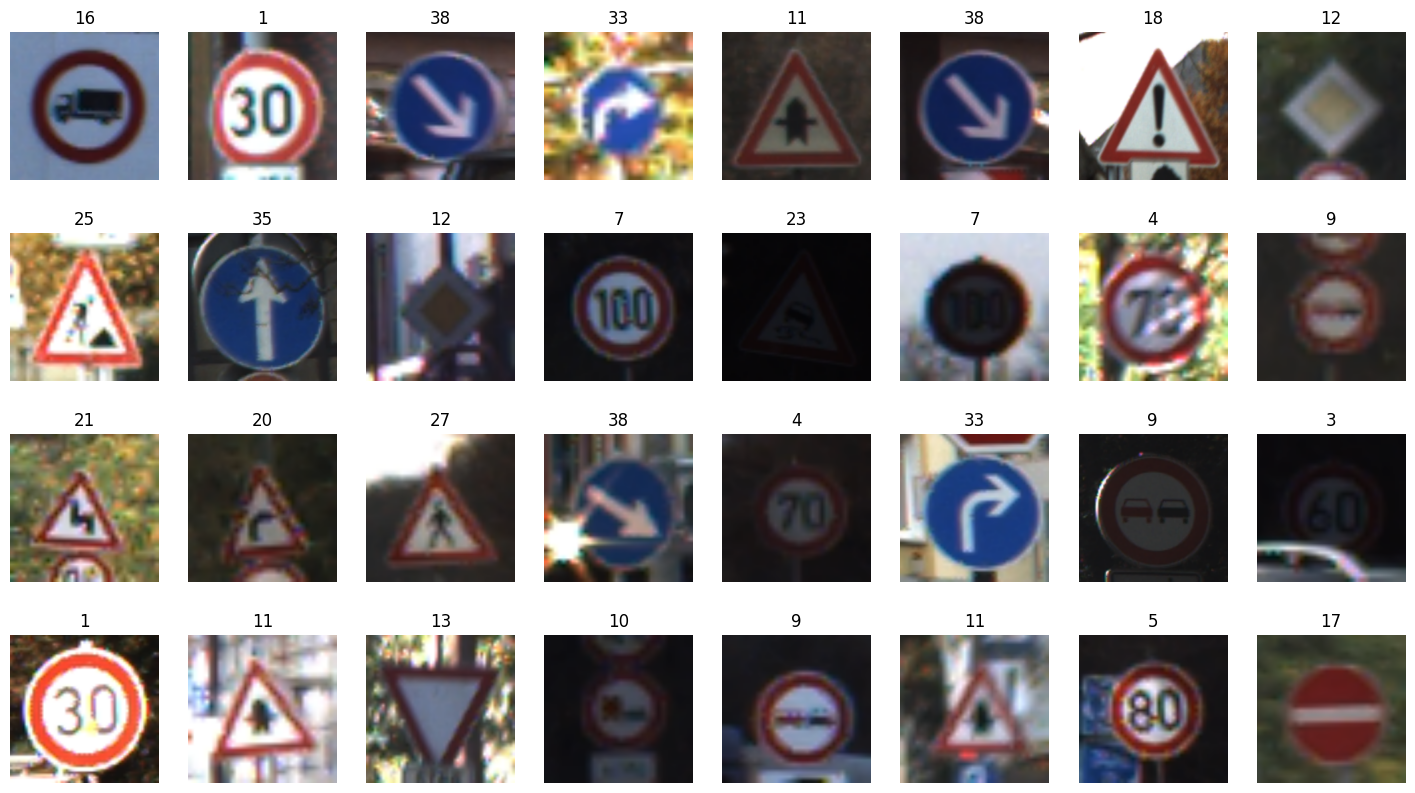

In [ ]:
plt.figure(figsize=(18,10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

# Loading the VGG-16 Convolutional base

In [ ]:
#specify the model input shape.
input_shape=(DatasetConfig.IMG_HEIGHT,DatasetConfig.IMG_WIDTH,DatasetConfig.CHANNELS)

print("Loading model with ImageNet weights...")

vgg16_conv_base=tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                include_top=False,  # we will supply our own top
                                                weights='imagenet',
                                                )
print(vgg16_conv_base.summary())

Loading model with ImageNet weights...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


# Now Freezing the initial layers in the convolutional base

Now we have to lock the initial layers so that the only the last few later layers are trainable. Training_config.LAYERS_FINE_TUNE=8.

Thereare teo methods to specify which layers in the model are trainable or tunable.


1.   We can start by making the entire convolution base trainable by setting the trainable flag to True. Then loop over the initial layers and make them untrainable by setting flag to False.
2.   we can freeze the entire convolutional base by setting the trainable flag to False, and then loop over the last few layers and set the trainable flag to True.

We choose the 1st one



In [ ]:
#set all layers in the convolutional base to trainable
vgg16_conv_base.trainable=True

#specify the number pf layers to fine tune at the end of the convolutional base
num_layers_fine_tune=TrainingConfig.LAYERS_FINE_TUNE
num_layers=len(vgg16_conv_base.layers)
print(f"Total layers- {num_layers}")
# freesing the initial layers of convolutional base
for layer in vgg16_conv_base.layers[:num_layers-num_layers_fine_tune]:
  print(f"Freezing layer -> {layer}")
  layer.trainable=False

print(f"\nConfigured to fine tune the last, {num_layers_fine_tune} layers")

print(vgg16_conv_base.summary())

Total layers- 19
Freezing layer -> <InputLayer name=input_layer_1, built=True>
Freezing layer -> <Conv2D name=block1_conv1, built=True>
Freezing layer -> <Conv2D name=block1_conv2, built=True>
Freezing layer -> <MaxPooling2D name=block1_pool, built=True>
Freezing layer -> <Conv2D name=block2_conv1, built=True>
Freezing layer -> <Conv2D name=block2_conv2, built=True>
Freezing layer -> <MaxPooling2D name=block2_pool, built=True>
Freezing layer -> <Conv2D name=block3_conv1, built=True>
Freezing layer -> <Conv2D name=block3_conv2, built=True>
Freezing layer -> <Conv2D name=block3_conv3, built=True>
Freezing layer -> <MaxPooling2D name=block3_pool, built=True>

Configured to fine tune the last, 8 layers


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

None


we can see the difference of trainable parameters from the above two summary

# Add a classifier to compute the model


In [ ]:
inputs=tf.keras.Input(shape=input_shape)
x=tf.keras.applications.vgg16.preprocess_input(inputs)
x=vgg16_conv_base(x)
x=layers.Flatten()(x)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(TrainingConfig.DROPOUT)(x)

# the final 'Dense layer with the number of classes.
outputs=layers.Dense(DatasetConfig.NUM_CLASSES,activation='softmax')(x)

#the final model
model_finetune=keras.Model(inputs,outputs)

print(model_finetune.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_18 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_19 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_20 (GetItem)     │ (None, 224, 224)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_6 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_18[0][0],     │
│                           │                        │                │ get_item_19[0][0],     │
│                           │                        │                │ get_item_20[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 25088)          │              0 │ vgg16[6][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │      3,211,392 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 43)             │          5,547 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,931,627 (68.40 MB)

 Trainable params: 16,196,139 (61.78 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

None


We use Sparse categorical cross entropy since we are using integer-encoded labels

Setting from_logits=False

This tells TensorFlow that the model output is already in probability format (because Softmax is applied in the model).
The loss function expects probability values and directly computes cross-entropy.

In [ ]:
model_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

In [ ]:
#train
model_trainning=model_finetune.fit(train_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                    validation_data=valid_dataset)

Epoch 1/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 774ms/step - accuracy: 0.0320 - loss: 6.6668 - val_accuracy: 0.0252 - val_loss: 3.7478
Epoch 2/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.0259 - loss: 3.7524 - val_accuracy: 0.0407 - val_loss: 3.7429
Epoch 3/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.0235 - loss: 3.7497 - val_accuracy: 0.0620 - val_loss: 3.7048
Epoch 4/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.0315 - loss: 3.7159 - val_accuracy: 0.0775 - val_loss: 3.6994
Epoch 5/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.0393 - loss: 3.6699 - val_accuracy: 0.0640 - val_loss: 3.5987
Epoch 6/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.0647 - loss: 3.6151 - val_accuracy: 0.0640 - val_loss: 3.5617
Epoch 7/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.0798 - loss: 3.5597 - val_accuracy: 0.0795 - val_loss: 3.4196
Epoch 8/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.0954 - loss: 3.4426 - 

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

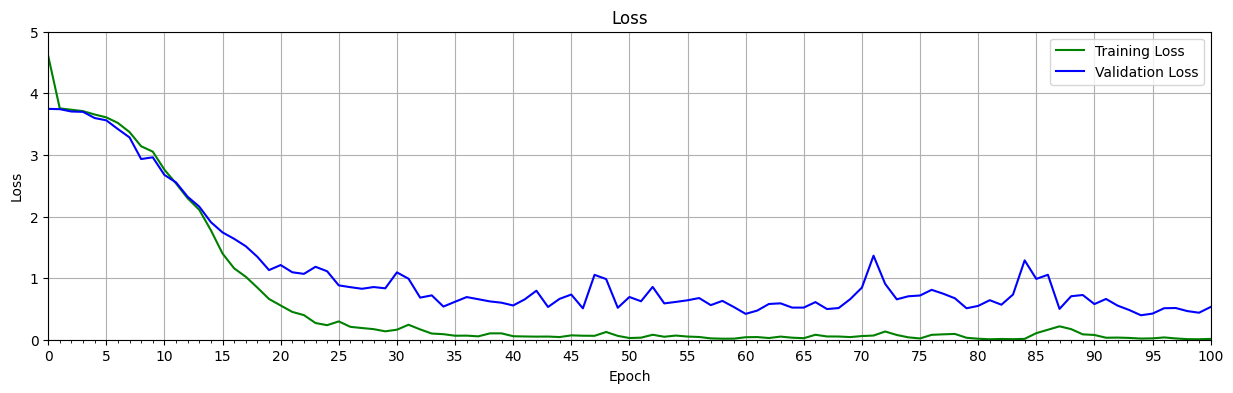

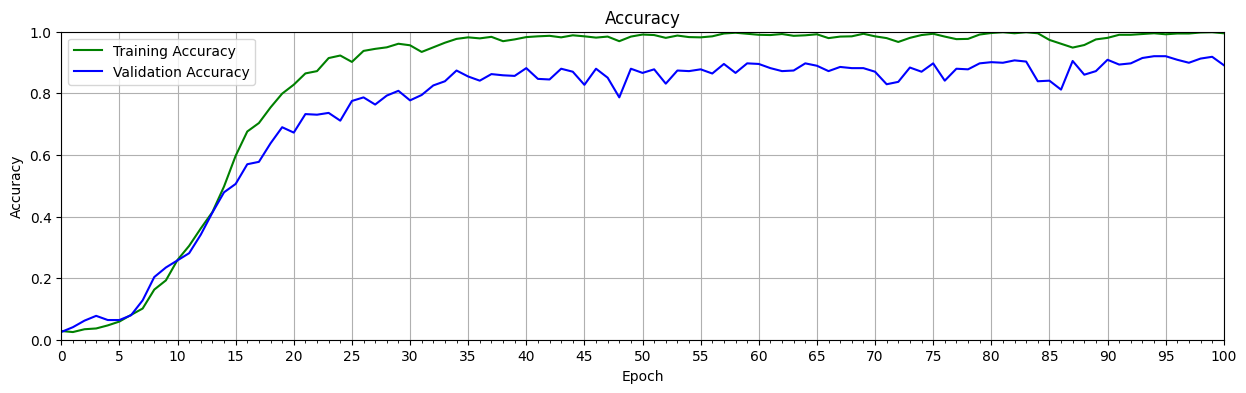

In [ ]:
# Retrieve training results.
train_loss = model_trainning.history["loss"]
train_acc  = model_trainning.history["accuracy"]
valid_loss = model_trainning.history["val_loss"]
valid_acc  = model_trainning.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

# Model Evaluation

In [ ]:
# validation dataset
print(f"Validation Dataset: Accuracy = {model_finetune.evaluate(valid_dataset)[1]*100}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8919 - loss: 0.5070
Validation Dataset: Accuracy = 89.147287607193


In [ ]:
#test dataset
print(f"Test Dataset: Accuracy = {model_finetune.evaluate(test_dataset)[1]*100}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.8992 - loss: 0.5340
Test Dataset: Accuracy = 89.7387146949768


In [ ]:
# display predictions

In [ ]:
def display_predictions(dataset, model, class_names):

    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0

    # Evaluate all the batches.
    for image_batch, labels_batch in dataset.take(2):

        print(image_batch.shape)

        # Predictions for the current batch.
        predictions = model.predict(image_batch)

        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()

            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'

            jdx += 1

            if jdx > num_rows*num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break

            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return

(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


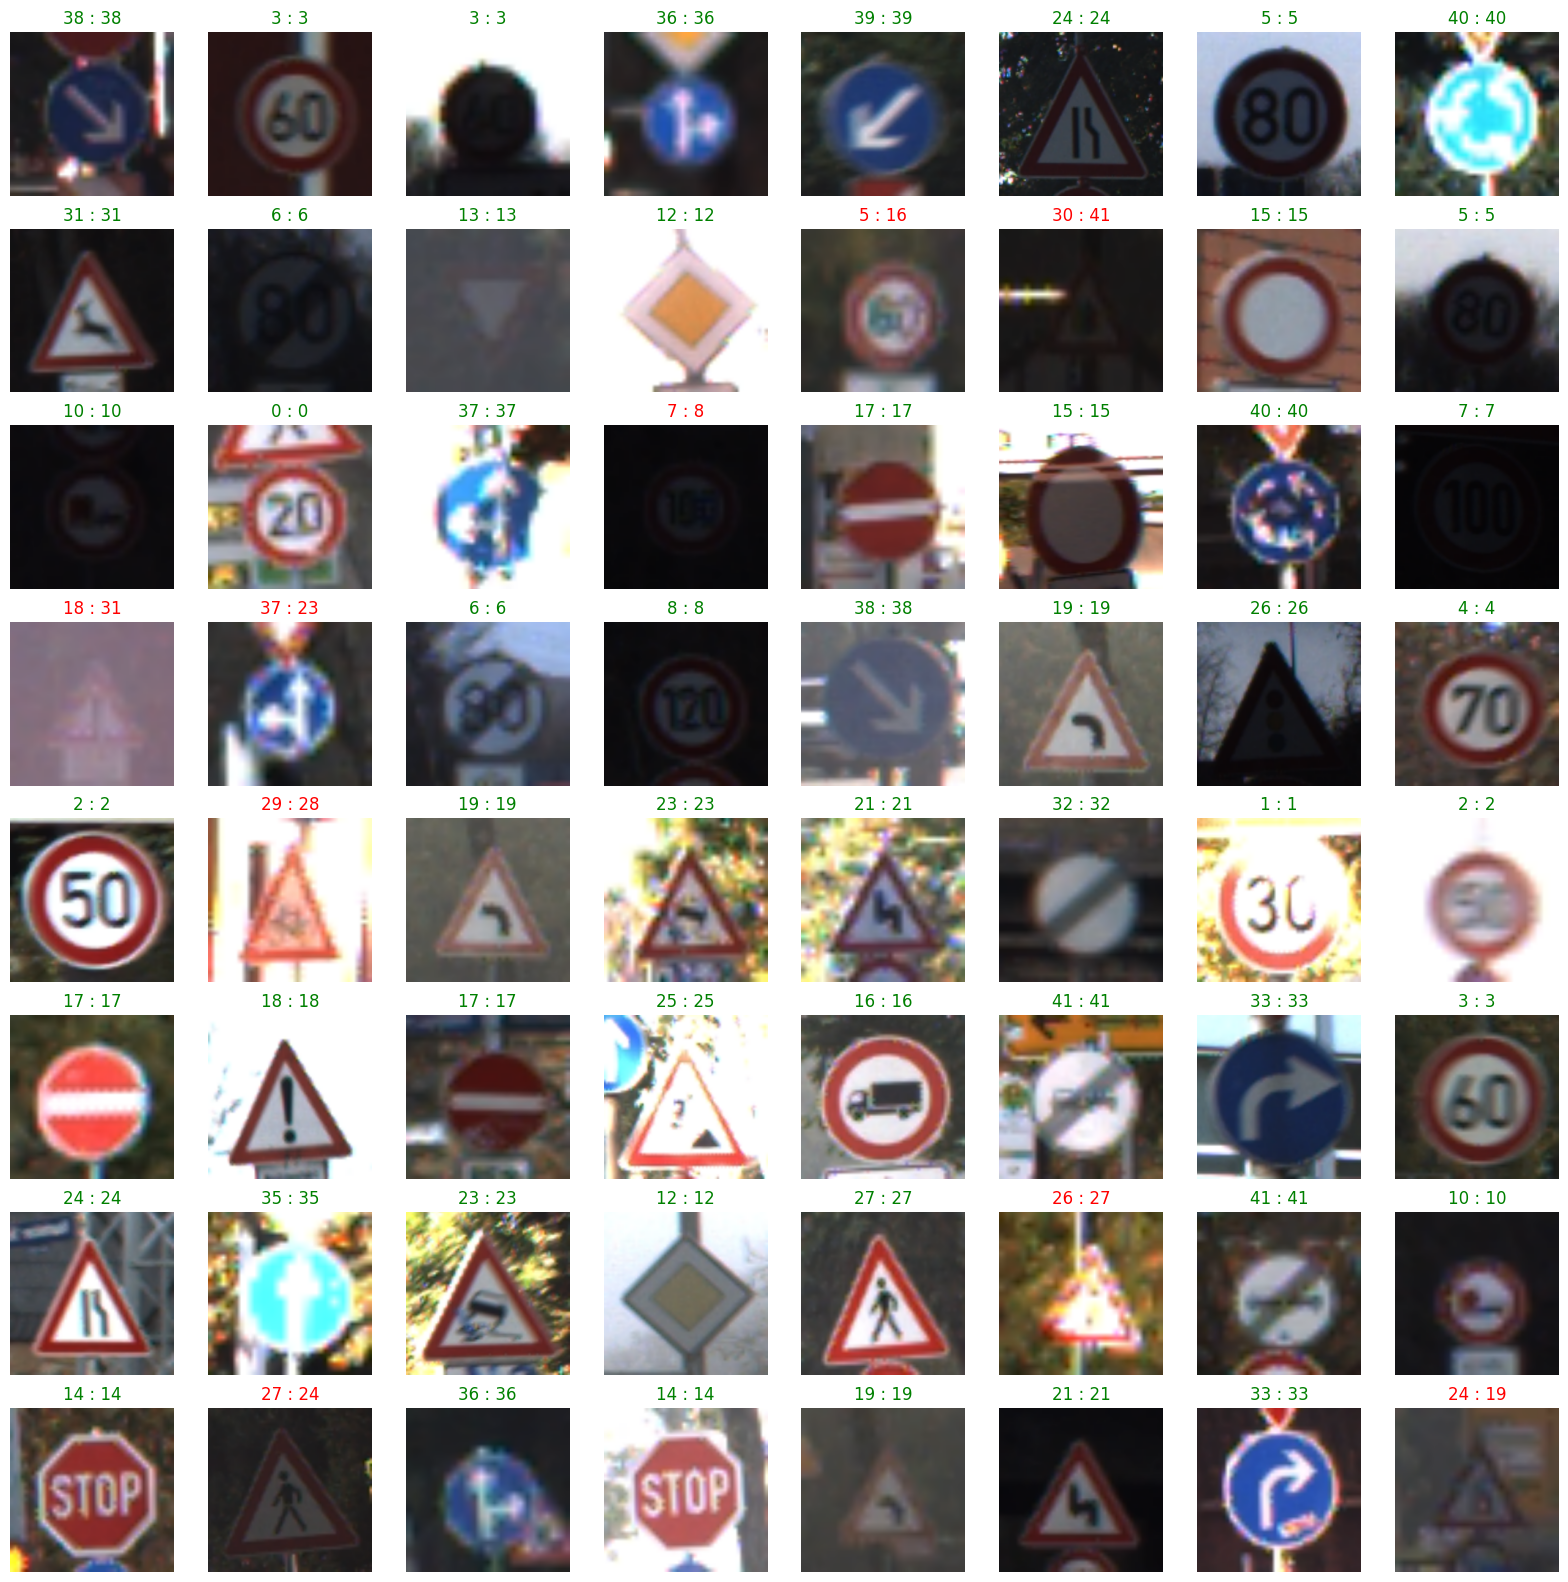

In [ ]:

display_predictions(valid_dataset,model_finetune,class_names)

(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


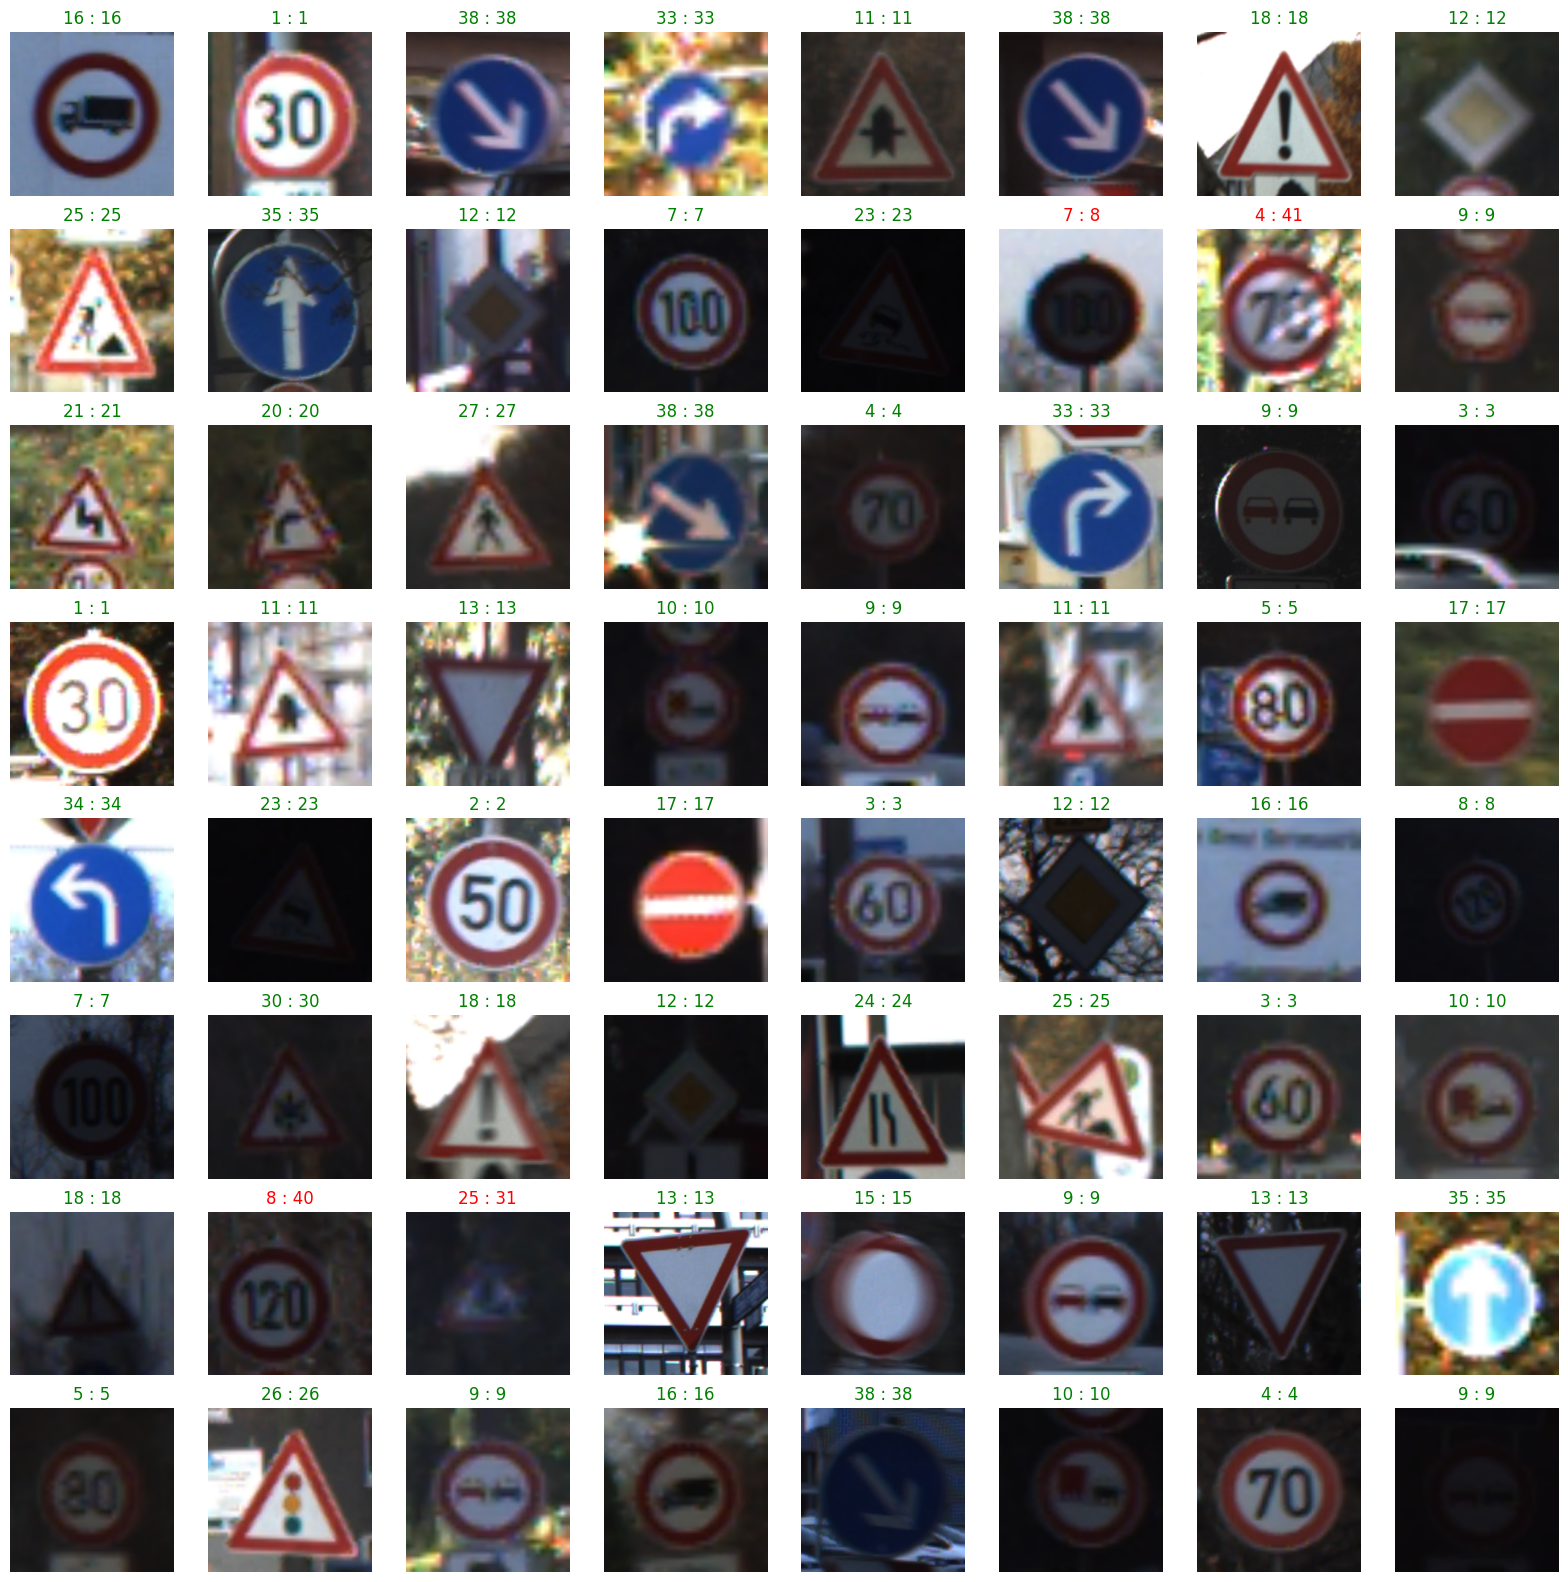

In [ ]:
display_predictions(test_dataset,model_finetune,class_names)